# Image Classification with PyTorch
### by Illia Nesterenko  

This notebook contains the code and subsequent commentaries on the training and evaluation of a CNN model for image classification on the Fashion-MNIST dataset.

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split
from torchsummary import summary

# for importing data
import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# download the dataset
cdata = torchvision.datasets.FashionMNIST(root='fmnist',download=True, train=True)
cdataTest = torchvision.datasets.FashionMNIST(root='fmnist',download=True, train=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 9874801.09it/s] 


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203834.62it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3721518.01it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15994279.25it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)
print(cdataTest.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([60000,1,28,28]).float()
imagesTest = cdataTest.data.view([10000,1,28,28]).float()
print('\nTensor data:')
print(images.shape)
print(imagesTest.shape)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10 classes

Data size:
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])

Tensor data:
torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [5]:
# remove the first class category
imgCategories = cdata.classes

# relabel labels to start at 0
labels = torch.Tensor(copy.deepcopy(cdata.targets)).long()
labelsTest = torch.Tensor(copy.deepcopy(cdataTest.targets)).long()
print(labels.shape)

###
print( torch.unique(labels) )

torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


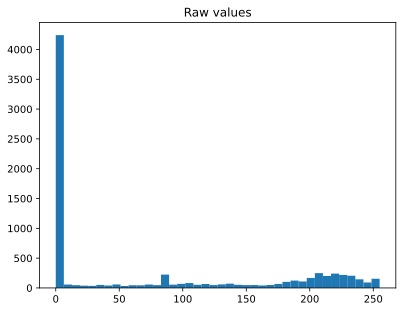

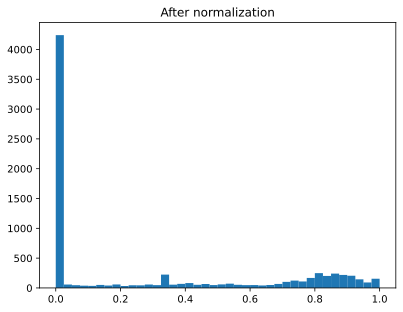

In [6]:
# normalize images
plt.hist(images[:10,0,:,:].reshape(1,-1).detach(),40);
plt.title('Raw values')
plt.show()

images /= torch.max(images)
imagesTest /= torch.max(imagesTest)

plt.hist(images[:10,0,:,:].reshape(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

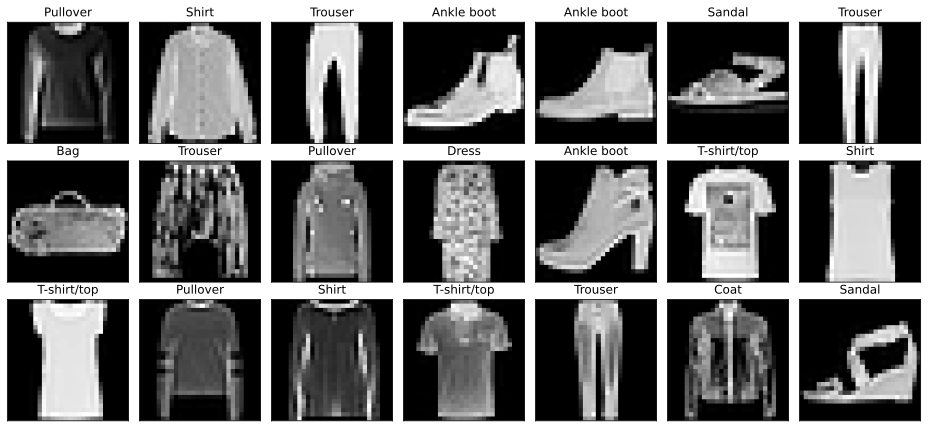

In [7]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = images.permute(0, 2, 3, 1)[whichpic,:,:,:]
  cat = imgCategories[labels[whichpic].long()]

  # visualize
  ax.imshow(I, cmap='gray')
  ax.set_title(f'{cat}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
# Step 2: use scikitlearn to split the data
dev_data, test_data, dev_labels,test_labels = train_test_split(imagesTest, labelsTest, test_size=.5)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(images,labels)
dev_data = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(test_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [9]:
dev_data.tensors[0].shape[0]

5000

In [10]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [11]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,24,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(24) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(24,96,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(96) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(96,192,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(192) # input the number of channels in this layer
      # output size: (7+2*1-3)/1 + 1 = 7/2 = 3 (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(3*3*192,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,128)
      self.fc4 = nn.Linear(128,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc3(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = self.fc4(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.NAdam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [12]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 24, 14, 14]
Second CPR block: [32, 96, 7, 7]
Third CPR block: [32, 192, 3, 3]
Vectorized: [32, 1728]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3044, grad_fn=<NllLossBackward0>)


In [13]:
summary(net.to(device), (1, 28, 28))

Input: [2, 1, 28, 28]
First CPR block: [2, 24, 14, 14]
Second CPR block: [2, 96, 7, 7]
Third CPR block: [2, 192, 3, 3]
Vectorized: [2, 1728]
Final output: [2, 10]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             240
       BatchNorm2d-2           [-1, 24, 14, 14]              48
            Conv2d-3           [-1, 96, 14, 14]          20,832
       BatchNorm2d-4             [-1, 96, 7, 7]             192
            Conv2d-5            [-1, 192, 7, 7]         166,080
       BatchNorm2d-6            [-1, 192, 3, 3]             384
            Linear-7                  [-1, 512]         885,248
            Linear-8                  [-1, 256]         131,328
            Linear-9                  [-1, 128]          32,896
           Linear-10                   [-1, 10]           1,290
Total params: 1,238,538
Trainable params: 1,238,538
Non-trainable pa

In [14]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 30

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  devErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)


    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainErr,devErr,net

In [15]:
trainLoss,devLoss,trainErr,devErr,net = function2trainTheModel()

In [ ]:
# xticks labels formatting
a = [0]
a.extend(range(4,31,5))
b = [1]
b.extend(range(5,32,5))

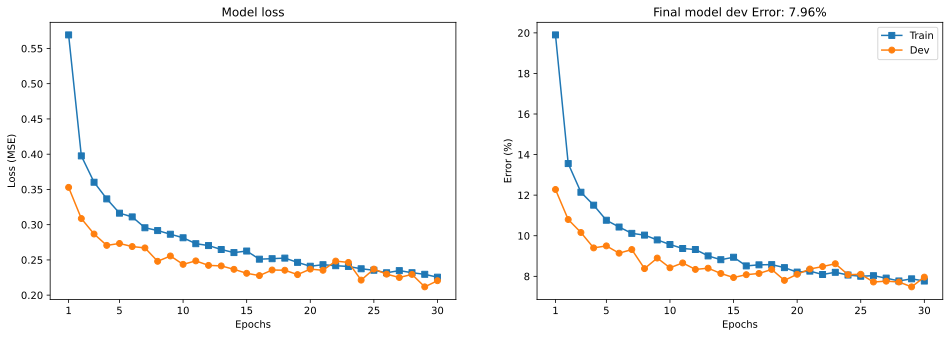

In [36]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].set_xticks(a)
ax[0].set_xticklabels(b)

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(devErr,'o-',label='Dev')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error (%)')
ax[1].set_title(f'Final model dev Error: {devErr[-1]:.2f}%')
ax[1].set_xticks(a)
ax[1].set_xticklabels(b)
ax[1].legend()

plt.show()

In [19]:
### test performance
net.eval()
X,y = next(iter(test_loader)) # extract X,y from test dataloader

# push data to GPU
X = X.to(device)
y = y.to(device)

with torch.no_grad(): # deactivates autograd
    yHat = net(X)
    loss = lossfun(yHat,y)

# get loss and error rate from the test batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

print(testLoss)
print(testAcc)

0.2205108106136322
92.03999638557434
